# Modelling and Evaluation

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve



[notice] A new release of pip available: 22.2.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import data and feature selection

In [73]:
df_fraud=pd.read_csv('C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/FraudDetectionCards/Data/fraud_resampled1.csv')
df_fraud=df_fraud.drop(columns=['Unnamed: 0', 'index'])

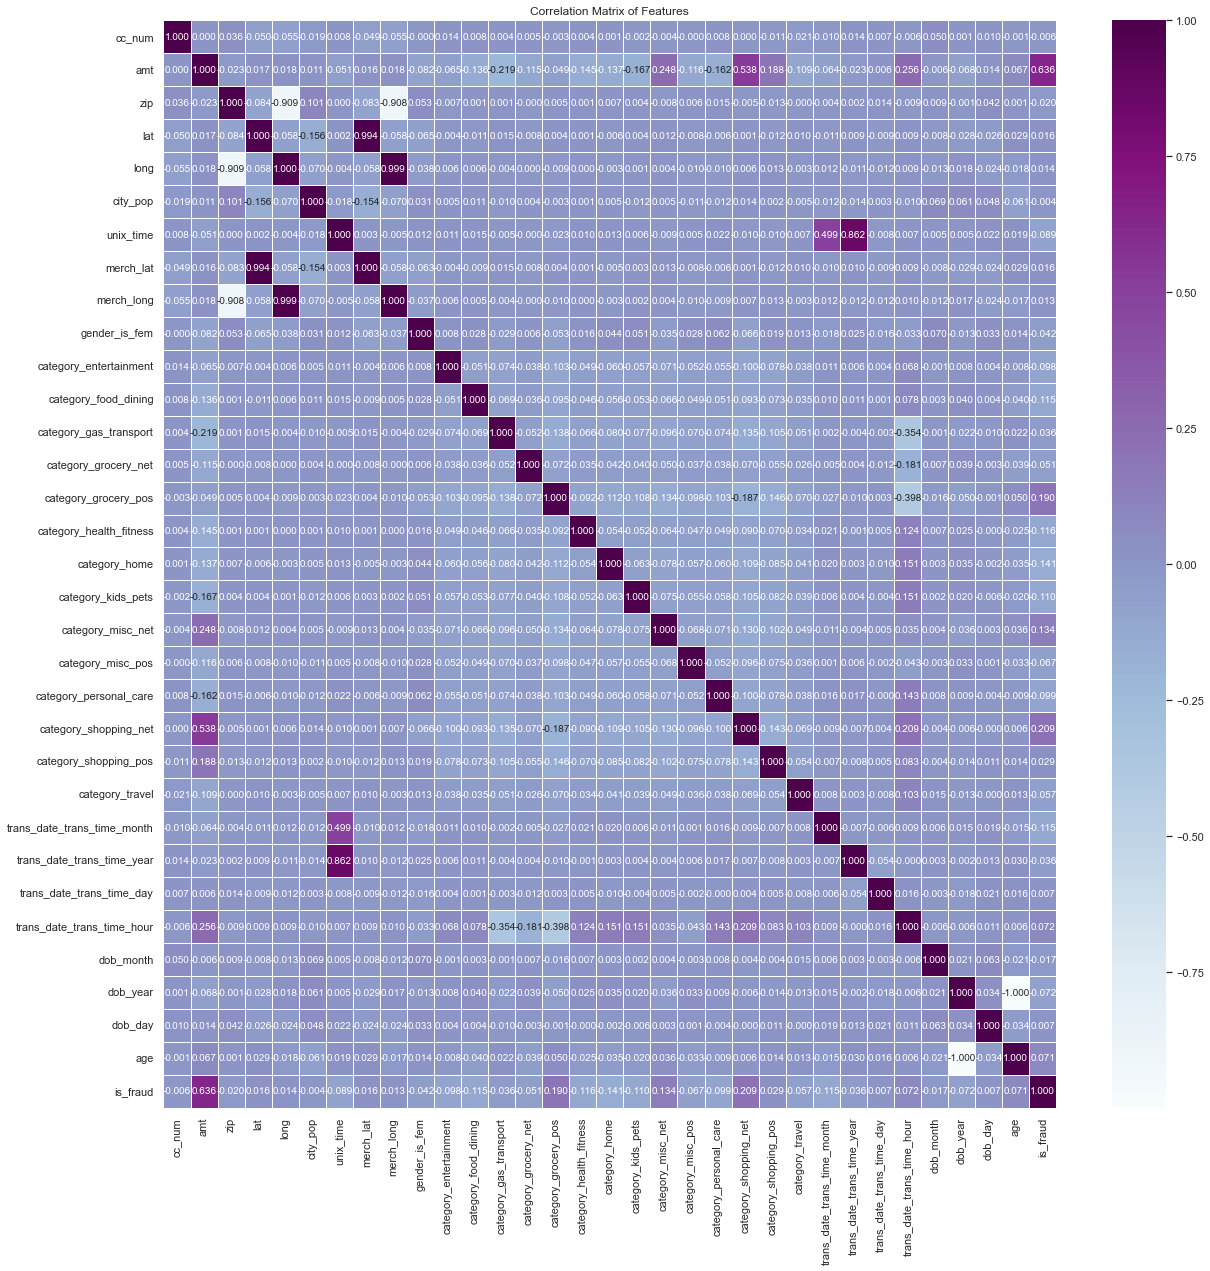

In [74]:
# Correlation Matrix to select features:
# Drop features that are similar (for instance age and dob year)
correlation_matrix = df_fraud.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.set( style = "white" ) 
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.3f', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Features')
plt.show()

In [75]:
to_exclude=['trans_date_trans_time', 'cc_num', 'merchant', 'category','first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'unix_time', 'Split','dob_month',
       'dob_year', 'dob_day','trans_date_trans_time_year','trans_date_trans_time_month', 'trans_date_trans_time_day','lat', 'long','merch_lat', 'merch_long']
df_fraud=df_fraud.drop(columns=to_exclude)

In [76]:
df_fraud.columns

Index(['amt', 'zip', 'city_pop', 'gender_is_fem', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'trans_date_trans_time_hour', 'age', 'is_fraud'],
      dtype='object')

# Split Test/Train

In [77]:
# 'is_fraud' is the target variable
X = df_fraud.drop('is_fraud', axis=1)
y = df_fraud['is_fraud']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1994)

print("Train: ",len(X_train))
print("Test: ",len(X_test))


Train:  15438
Test:  3860


# Models + Cross Validation

## Random Forest Classifier

RandomForestClassifier(max_depth=10, min_samples_leaf=300, random_state=1994)


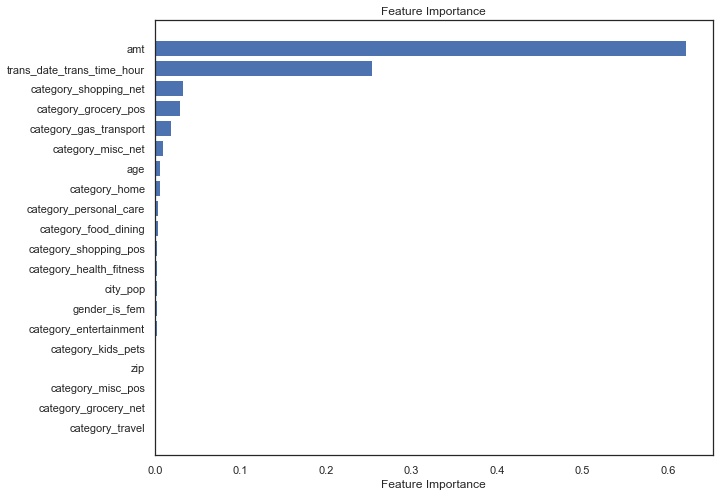

In [78]:
rf = RandomForestClassifier(random_state=1994,min_samples_leaf=300)
rf_params = {
    'n_estimators': [100], #, 200, 300
    'max_depth': [10, 20], #, 20, 30
    # 'min_samples_split': [2, 5, 10]
}

#Evaluating on F1 due to 
rf_grid = GridSearchCV(rf, rf_params, cv=4, scoring='f1')
rf_grid.fit(X_train, y_train)

# Best RF Model
best_rf = rf_grid.best_estimator_
print(best_rf)

# Feature Importance
feature_importance = best_rf.feature_importances_
feature_names = X.columns
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

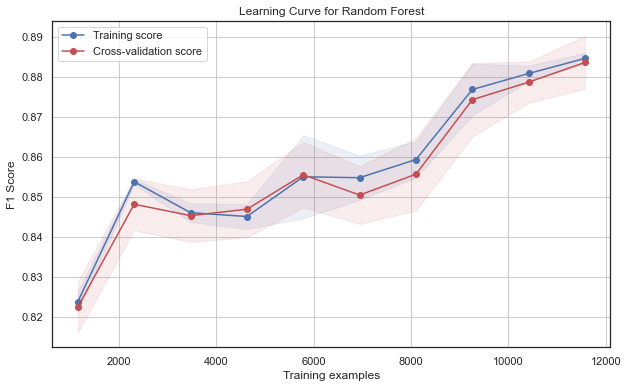

In [79]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Random Forest Results:
                  0
Accuracy   0.926425
Precision  0.945886
Recall     0.902054
F1 Score   0.923450
ROC AUC    0.926040


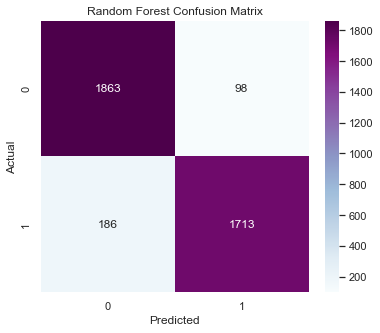

In [80]:
# Evaluating best RF model on the test set
y_pred_rf = best_rf.predict(X_test)
rf_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'ROC AUC': roc_auc_score(y_test, y_pred_rf),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_rf)
}

print("Random Forest Results:")
print(pd.DataFrame({k: [v] for k, v in rf_results.items() if k != 'Confusion Matrix'}).T)

plt.figure(figsize=(6, 5))
sns.heatmap(rf_results['Confusion Matrix'], annot=True, fmt='d', cmap='BuPu')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGBoost Classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=1994, ...)


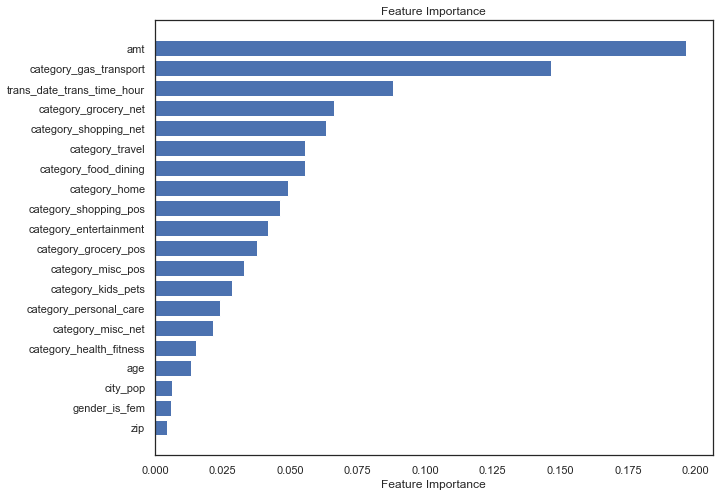

In [81]:
xgb = XGBClassifier(random_state=1994, eval_metric='logloss')
xgb_params = {
    'n_estimators': [100], #200, 300],
    'max_depth': [3,5],# 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=4, scoring='f1')
xgb_grid.fit(X_train, y_train)

# Best XGBoost Model
best_xgb = xgb_grid.best_estimator_
print(best_xgb)

# Feature Importance
feature_importance = best_xgb.feature_importances_
feature_names = X.columns
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

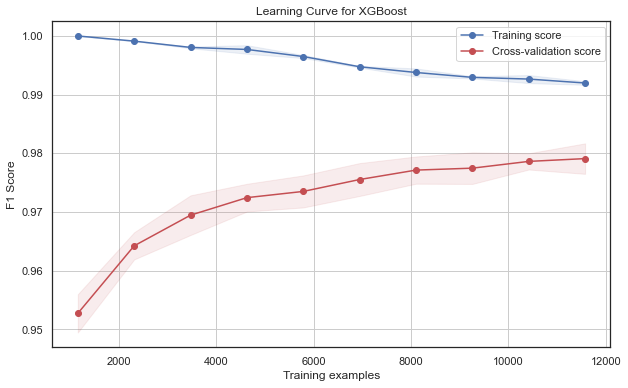

In [82]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.title("Learning Curve for XGBoost")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid()
plt.show()

XGBoostResults:
                  0
Accuracy   0.926425
Precision  0.945886
Recall     0.902054
F1 Score   0.923450
ROC AUC    0.926040


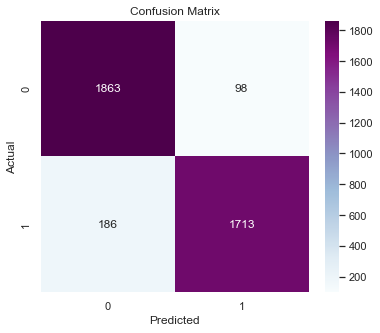

In [83]:
# Evaluating the best XGBoost model on the test set
y_pred_xgb = best_xgb.predict(X_test)
xgb_results = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'ROC AUC': roc_auc_score(y_test, y_pred_xgb),
    'Confusion Matrix': confusion_matrix(y_test, y_pred_xgb)
}

print("XGBoostResults:")
print(pd.DataFrame({k: [v] for k, v in rf_results.items() if k != 'Confusion Matrix'}).T)

plt.figure(figsize=(6, 5))
sns.heatmap(rf_results['Confusion Matrix'], annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Comparing All Models

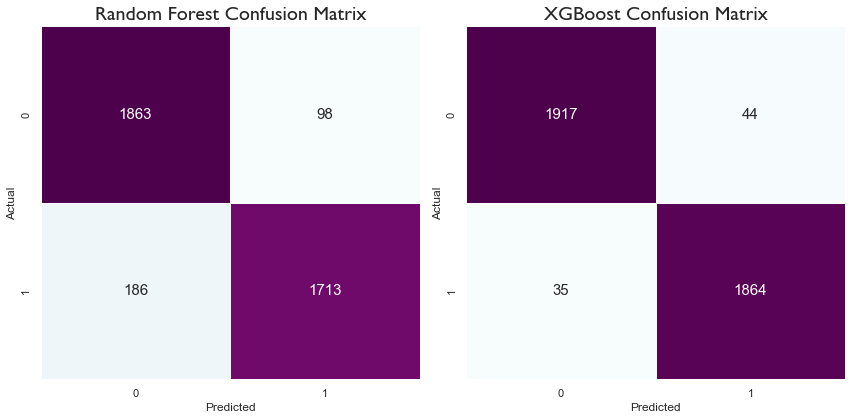

Comparison of Best Models:
               Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest  0.926425   0.945886  0.902054  0.923450  0.926040
XGBoost        0.979534   0.976939  0.981569  0.979249  0.979566


In [90]:

# Comparing all models
models = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

results = {
    'Random Forest': rf_results,
    'XGBoost': xgb_results
}

# Plotting confusion matrices
fig, axes = plt.subplots(1, len(results.keys()), figsize=(12, 6))

for ax, (name, result) in zip(axes, results.items()):
    cm = result['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False, cmap='BuPu', linewidths=0.5, annot_kws={"size": 15})
    ax.set_title(f'{name} Confusion Matrix', fontdict={'fontsize': 20,'fontname':"Gill Sans MT"})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Displaying the comparison results
results_df = pd.DataFrame({name: {metric: result[metric] for metric in result if metric != 'Confusion Matrix'} for name, result in results.items()})
print("Comparison of Best Models:")
print(results_df.T)
